## Partie modélisation

In [48]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

In [7]:
# Définir les tranches de BMI
bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']

# Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

In [8]:
del df["index"]
df.head()

,age,sex,bmi,children,smoker,region,charges,BMI_category
0,19,female,27.900,0,yes,southwest,16884.92400,Surpoids
1,18,male,33.770,1,no,southeast,1725.55230,Obésité
2,28,male,33.000,3,no,southeast,4449.46200,Obésité
3,33,male,22.705,0,no,northwest,21984.47061,Poids normal
4,32,male,28.880,0,no,northwest,3866.85520,Surpoids


In [9]:
features_of_interest = [
    "age",
    "sex",
    "children",
    "smoker",
    "region",
    "bmi",
    "BMI_category"
]

numerical_column = [
    "age",
    "bmi",
    "children"
]

ordinal_column = [
    "sex",
    "smoker",
    "BMI_category"
]

categorical_column = [
    "region",
]


target_name = "charges"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

### Training set

On prend un training set en faisant attention à la proportion de fumeur qui est importante :

In [10]:
X_train, X_test, y_train, y_test =train_test_split(data,target,random_state=42, test_size=0.15, stratify=df["smoker"])

### dummy model

In [11]:
dummy_model = DummyRegressor()
_ = dummy_model.fit(X_train,y_train)

In [12]:
target_predicted = dummy_model.predict(X_test)
target_predicted

array([13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
      

On obtient bien un modèle qui nous prédit pour tout le monde la moyenne des charges...

In [13]:
rmse = root_mean_squared_error(dummy_model.predict(X_test), y_test)
rmse

12054.89618229247

Avec un rmse de 12105 ce qui est beaucoup

### première regression linéaire

Les r2 pour nos valeurs numériques :

In [14]:
r_regression(numerical_data, target)

array([0.29830821, 0.19840083, 0.06738935])

In [15]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, LinearRegression())
linear_model.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [16]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [17]:
cv_results = cross_validate(
    linear_model,
    data,
    target,
    cv=10,
    scoring={"r2": "r2", "rmse":rmse_scorer},
    return_train_score=True,
    return_estimator=True,
)

In [18]:
cv_results["test_r2"].mean()

np.float64(0.7476344361036628)

In [19]:
cv_results["test_rmse"].mean()

np.float64(-6025.097924357421)

On obtient en moyenne un rmse d'environ 6000 ce qui est toujours mieux que le dummy model mais pas tant...

### avec polynomiale features

In [20]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())
linear_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [21]:
root_mean_squared_error(linear_model.predict(X_test), y_test)

3529.0487401574833

In [22]:
linear_model.score(X_test,y_test)

0.9140591572092805

On obtient un meilleur score. Etudions le poid de nos nouvelles features :

In [23]:
pd.set_option("display.max_columns", 100)
pd.DataFrame(data = [linear_model[-1].coef_ ], columns=linear_model[:2].get_feature_names_out())


,1,categorical__region_northeast,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,ordinal__sex,ordinal__smoker,ordinal__BMI_category,numeric__age,numeric__bmi,numeric__children,categorical__region_northeast^2,categorical__region_northeast categorical__region_northwest,categorical__region_northeast categorical__region_southeast,categorical__region_northeast categorical__region_southwest,categorical__region_northeast ordinal__sex,categorical__region_northeast ordinal__smoker,categorical__region_northeast ordinal__BMI_category,categorical__region_northeast numeric__age,categorical__region_northeast numeric__bmi,categorical__region_northeast numeric__children,categorical__region_northwest^2,categorical__region_northwest categorical__region_southeast,categorical__region_northwest categorical__region_southwest,categorical__region_northwest ordinal__sex,categorical__region_northwest ordinal__smoker,categorical__region_northwest ordinal__BMI_category,categorical__region_northwest numeric__age,categorical__region_northwest numeric__bmi,categorical__region_northwest numeric__children,categorical__region_southeast^2,categorical__region_southeast categorical__region_southwest,categorical__region_southeast ordinal__sex,categorical__region_southeast ordinal__smoker,categorical__region_southeast ordinal__BMI_category,categorical__region_southeast numeric__age,categorical__region_southeast numeric__bmi,categorical__region_southeast numeric__children,categorical__region_southwest^2,categorical__region_southwest ordinal__sex,categorical__region_southwest ordinal__smoker,categorical__region_southwest ordinal__BMI_category,categorical__region_southwest numeric__age,categorical__region_southwest numeric__bmi,categorical__region_southwest numeric__children,ordinal__sex^2,ordinal__sex ordinal__smoker,ordinal__sex ordinal__BMI_category,ordinal__sex numeric__age,ordinal__sex numeric__bmi,ordinal__sex numeric__children,ordinal__smoker^2,ordinal__smoker ordinal__BMI_category,ordinal__smoker numeric__age,ordinal__smoker numeric__bmi,ordinal__smoker numeric__children,ordinal__BMI_category^2,ordinal__BMI_category numeric__age,ordinal__BMI_category numeric__bmi,ordinal__BMI_category numeric__children,numeric__age^2,numeric__age numeric__bmi,numeric__age numeric__children,numeric__bmi^2,numeric__bmi numeric__children,numeric__children^2
0,-6.024457e-13,447.604476,13.819621,105.778935,-567.203032,-287.9707,12676.5631,-751.701474,2686.949053,105.880069,791.514127,447.604476,1.818989e-12,2.501110e-12,-2.472689e-12,-426.568566,2642.737412,-40.993145,267.18081,701.227964,345.539557,13.819621,-2.728484e-12,3.183231e-12,221.249949,4009.925831,-314.093548,533.133432,-199.64245,541.440876,105.778935,1.818989e-12,-16.229474,2626.678256,-427.187546,1071.346464,-500.559137,-49.71252,-567.203032,-66.422609,3397.2216,30.572764,815.288346,104.853692,-45.753786,-287.9707,-257.365431,93.149413,176.634567,162.830086,-89.638325,12676.5631,-2831.913005,-296.28139,6438.652876,-446.239804,210.609943,109.629095,-191.978132,109.730448,835.79869,132.679372,-39.961691,-49.51375,135.975453,-146.220769


In [24]:
weights = linear_model[-1].coef_ 
null_features_weight = [w for w in weights if abs(w) < 0.001]
len(null_features_weight)

7

On a 7 des features dont on peut se débarasser. Utilisons maintenant Lasso.

### avec lasso

In [25]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", StandardScaler(), numerical_column)
    ],
    remainder="passthrough",
)

lasso_model = make_pipeline(preprocessor, PolynomialFeatures(2), Lasso(1))
lasso_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=1))])

In [26]:
lasso_model.score(X_test,y_test)

0.9141747458327049

In [27]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3526.674693515753

Pas de gain significatif. Faison une étude Pour trouver les meilleurs hyper paramètres : 

### Hyperparamètre tuning Lasso

In [98]:
lasso_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("lasso", Lasso())
])

param_grid = {
    "poly__degree": [2, 3], 
    "lasso__alpha": np.linspace(1, 40000, 50), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+08, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.380e+09, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarn

{'lasso__alpha': np.float64(1.0), 'poly__degree': 2}

In [29]:
grid_search.best_score_

np.float64(0.8465132589406533)

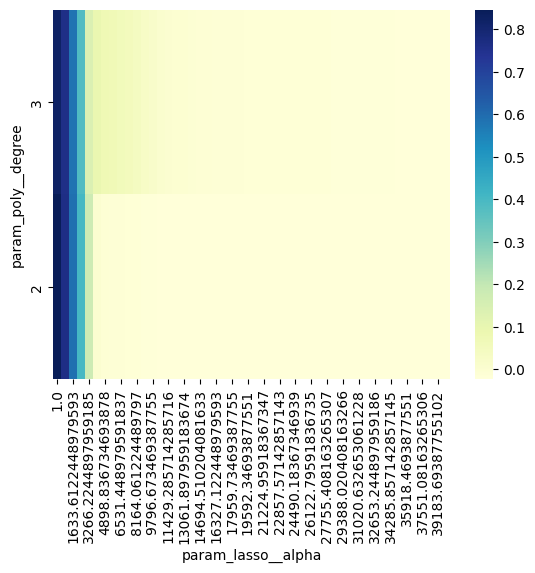

In [99]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__degree"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

on peut abandoner le degre 3 et on va se concentrer sur des valeurs de alpha entre 0 et 1000...

In [31]:
param_grid = {
    "lasso__alpha": np.linspace(1, 1000, 1000), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.513e+08, tolerance: 1.298e+07
  model = cd_fast.enet_coordinate_descent(


{'lasso__alpha': np.float64(45.0)}

In [32]:
grid_search.best_score_

np.float64(0.8488535242063835)

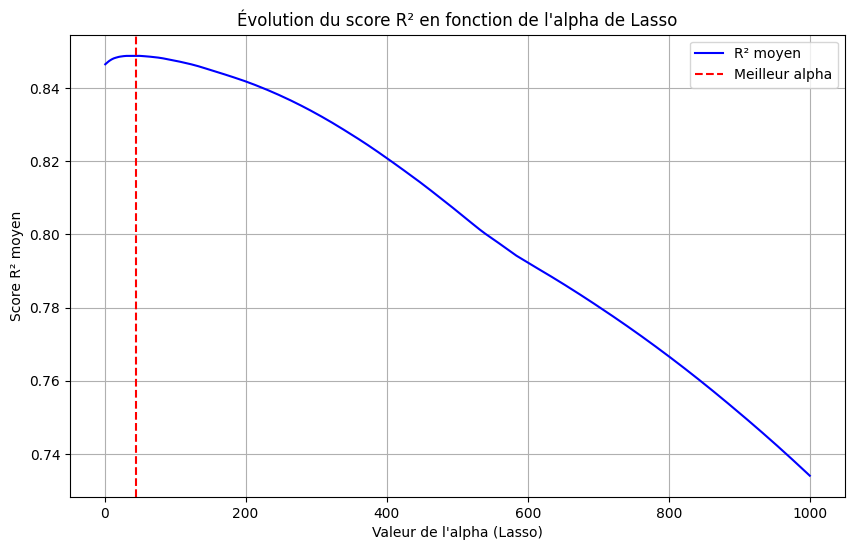

In [33]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

Le meilleur alpha semble être 45. Essayons tout de même entre 0 et 1 :

In [34]:
param_grid = {
    "lasso__alpha": np.linspace(0, 1, 101), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.684e+09, tolerance: 1.315e+07 Linear regression models wit

{'lasso__alpha': np.float64(1.0)}

In [35]:
grid_search.best_score_

np.float64(0.8465132589406533)

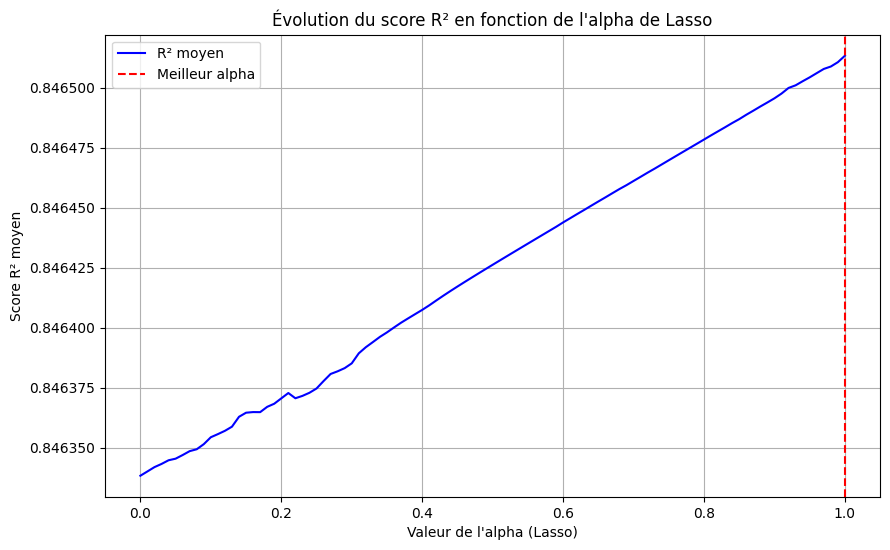

In [37]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

45 et meilleur. Etudions maintenant les carrés du polynôme avec un alpha pour alpha entre 35 et 55 :

In [94]:
param_grid = {
    "poly__interaction_only": [True, False], 
    "lasso__alpha": np.linspace(35, 55, 21), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lasso__alpha': np.float64(45.0), 'poly__interaction_only': False}

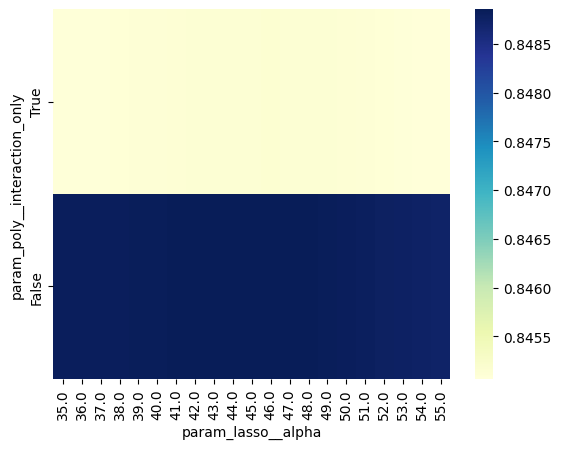

In [96]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__interaction_only"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

On a de meilleurs résultats en conservant les carrés...

In [40]:
lasso_model.set_params(poly__degree=2, lasso__alpha=45)
lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('poly', PolynomialFeatures()), ('lasso', Lasso(alpha=45))])

In [41]:
lasso_model.score(X_test,y_test)

0.9163676239507009

L'amélioration est tout de même peu significative...

In [42]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3481.329018061639

In [51]:
lasso_model.set_params(poly__degree=2, lasso__alpha=45)
lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('poly', PolynomialFeatures()), ('lasso', Lasso(alpha=45))])

In [52]:
lasso_model.score(X_test,y_test)

0.9163676239507009

In [53]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3481.329018061639

### Elastic net

In [80]:
elastic_net_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("elastic", ElasticNet())
])
elastic_net_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker',
                                                   'BMI_category']),
                                                 ('numeric', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('poly', PolynomialFeatures()), ('elastic', ElasticNet())])

In [81]:
ElasticNet().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [82]:
elastic_net_model.score(X_test,y_test)

0.6605484405133737

In [83]:
root_mean_squared_error(elastic_net_model.predict(X_test), y_test)

7013.693067995419

In [84]:
param_grid = {
    "elastic__l1_ratio": np.linspace(0, 1, 20), 
    "elastic__alpha": np.linspace(1, 100, 20)
}

grid_search = GridSearchCV(
    elastic_net_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.558e+10, tolerance: 1.315e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/utilisateur/Documents/Simplon/Brief_Prime_Assurance/Assur_aimant/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.590e+10, tolerance: 1.298e+07 Linear regression models wit

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'BMI_category']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('elastic', ElasticNet())]),
             param_grid={'ela...
        42.68421053,  47.89473684,  53.10526316,  58.31578947,
        63.52631579,  68.73684211,  73.94736842,  79.15789474,
        84.36842105,  89.57894737,  94.78947368, 100.        ]),
                         'elastic__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='r2')

In [85]:
print(grid_search.best_params_, grid_search.best_score_)

{'elastic__alpha': np.float64(42.68421052631579), 'elastic__l1_ratio': np.float64(1.0)} 0.8488488392449653


In [86]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elastic__alpha,param_elastic__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
179,0.011313,0.000858,0.004640,0.001017,42.684211,1.0,"{'elastic__alpha': 42.68421052631579, 'elastic...",0.822873,0.888374,0.865645,0.849705,0.817647,0.848849,0.026432,1
199,0.010547,0.000268,0.004189,0.000116,47.894737,1.0,"{'elastic__alpha': 47.89473684210526, 'elastic...",0.823074,0.888442,0.865583,0.849653,0.817459,0.848842,0.026450,2
159,0.011484,0.000677,0.004576,0.000605,37.473684,1.0,"{'elastic__alpha': 37.473684210526315, 'elasti...",0.822716,0.888280,0.865626,0.849733,0.817749,0.848821,0.026409,3
139,0.011070,0.000410,0.004118,0.000137,32.263158,1.0,"{'elastic__alpha': 32.26315789473684, 'elastic...",0.822539,0.888250,0.865550,0.849783,0.817909,0.848806,0.026389,4
219,0.012413,0.001480,0.005521,0.000836,53.105263,1.0,"{'elastic__alpha': 53.10526315789473, 'elastic...",0.823269,0.888478,0.865331,0.849608,0.817115,0.848760,0.026473,5


In [87]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

,param_elastic__l1_ratio,param_elastic__alpha,mean_test_score,std_test_score,rank_test_score
179,1.000000,42.684211,0.848849,0.026432,1
199,1.000000,47.894737,0.848842,0.026450,2
159,1.000000,37.473684,0.848821,0.026409,3
139,1.000000,32.263158,0.848806,0.026389,4
219,1.000000,53.105263,0.848760,0.026473,5
...,...,...,...,...,...
382,0.105263,100.000000,0.003422,0.026942,396
361,0.052632,94.789474,0.003392,0.026935,397
360,0.000000,94.789474,0.002371,0.026796,398
381,0.052632,100.000000,0.002344,0.026794,399


In [ ]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_elastic__l1_ratio"],
    columns=["param_elastic__alpha"],
    )

param_elastic__alpha,1.000000,6.210526,11.421053,16.631579,21.842105,27.052632,32.263158,37.473684,42.684211,47.894737,53.105263,58.315789,63.526316,68.736842,73.947368,79.157895,84.368421,89.578947,94.789474,100.000000
param_elastic__l1_ratio,,,,,,,,,,,,,,,,,,,,
0.000000,0.432846,0.143645,0.088528,0.063456,0.048766,0.038970,0.031891,0.026489,0.022202,0.018697,0.015764,0.013265,0.011103,0.009211,0.007536,0.006041,0.004696,0.003479,0.002371,0.001358
0.052632,0.443511,0.149498,0.092628,0.066670,0.051444,0.041284,0.033945,0.028347,0.023906,0.020277,0.017242,0.014656,0.012421,0.010463,0.008732,0.007186,0.005796,0.004538,0.003392,0.002344
0.105263,0.454824,0.155870,0.097113,0.070195,0.054382,0.043824,0.036198,0.030384,0.025774,0.022008,0.018859,0.016179,0.013862,0.011833,0.010039,0.008438,0.006999,0.005695,0.004509,0.003422
0.157895,0.466852,0.162839,0.102045,0.074080,0.057623,0.046627,0.038684,0.032630,0.027832,0.023914,0.020640,0.017854,0.015447,0.013340,0.011478,0.009816,0.008321,0.006968,0.005736,0.004608
0.210526,0.479674,0.170499,0.107496,0.078387,0.061218,0.049739,0.041443,0.035122,0.030113,0.026027,0.022614,0.019710,0.017202,0.015008,0.013069,0.011339,0.009783,0.008375,0.007093,0.005920
0.263158,0.493379,0.178965,0.113561,0.083192,0.065234,0.053218,0.044528,0.037907,0.032663,0.028386,0.024816,0.021780,0.019159,0.016867,0.014841,0.013035,0.011411,0.009942,0.008604,0.007380
0.315789,0.508072,0.188380,0.120355,0.088592,0.069756,0.057137,0.048005,0.041045,0.035534,0.031041,0.027293,0.024107,0.021358,0.018955,0.016832,0.014939,0.013238,0.011700,0.010299,0.009017
0.368421,0.523876,0.198924,0.128026,0.094712,0.074893,0.061590,0.051960,0.044615,0.038799,0.034058,0.030106,0.026748,0.023852,0.021322,0.019088,0.017097,0.015308,0.013691,0.012219,0.010872
0.421053,0.540934,0.210827,0.136767,0.101716,0.080787,0.066706,0.056503,0.048718,0.042552,0.037526,0.033338,0.029781,0.026714,0.024037,0.021674,0.019569,0.017679,0.015970,0.014415,0.012993


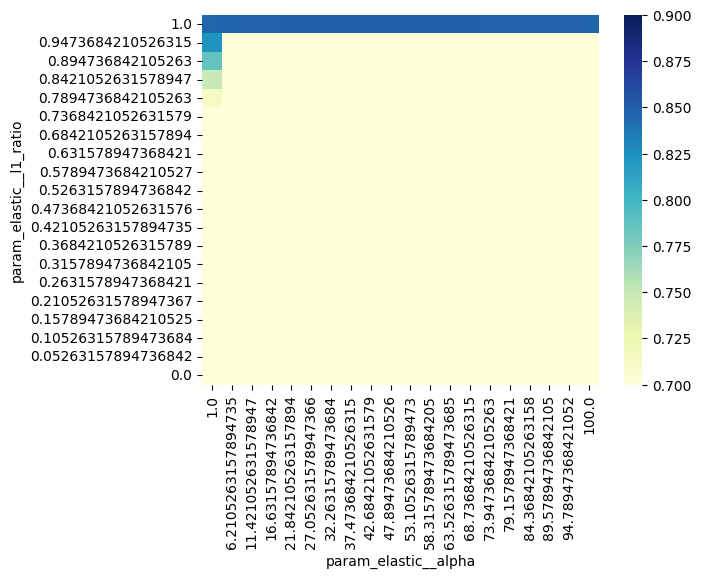

In [ ]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

In [100]:
param_grid = {
    "elastic__l1_ratio": np.linspace(0.9, 1, 20), 
    "elastic__alpha": np.linspace(50, 150, 100)
}

grid_search = GridSearchCV(
    elastic_net_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(),
                                                                         ['region']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'BMI_category']),
                                                                        ('numeric',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children'])])),
                                       ('poly', PolynomialFeatures()),
                                       ('elastic', ElasticNet())]),
             param_grid={'ela...
       138.88888889, 139.8989899 , 140.90909091, 141.91919192,
       142.92929293, 143.93939394, 144.94949495, 145.95959596,
       146.96969697, 147.97979798, 148.98989899, 150.        ]),
                         'elastic__l1_ratio': array([0.9       , 0.90526316, 0.91052632, 0.91578947, 0.92105263,
       0.92631579, 0.93157895, 0.93684211, 0.94210526, 0.94736842,
       0.95263158, 0.95789474, 0.96315789, 0.96842105, 0.97368421,
       0.97894737, 0.98421053, 0.98947368, 0.99473684, 1.        ])},
             scoring='r2')

In [92]:
print(grid_search.best_params_, grid_search.best_score_)

{'elastic__alpha': np.float64(50.0), 'elastic__l1_ratio': np.float64(1.0)} 0.8488131936386333


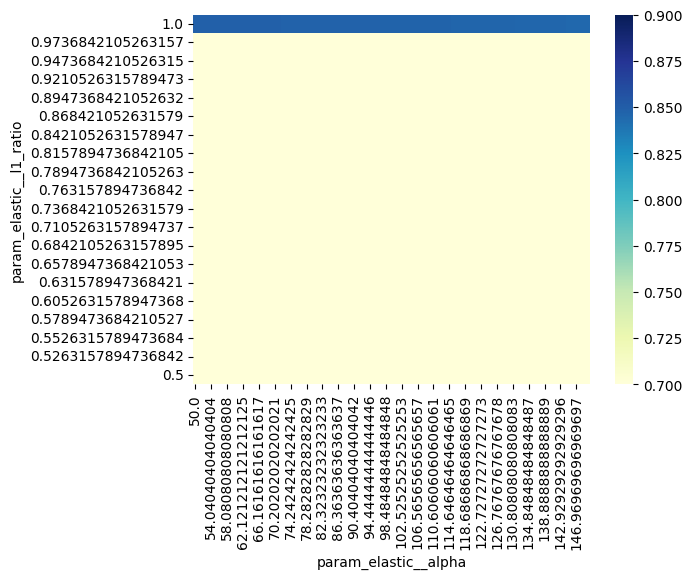

In [93]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_elastic__l1_ratio"],
    columns=["param_elastic__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()
